In [67]:
import io
import os
import re
import sys
import csv
import gzip
import time
import json
import pickle
import secrets
import multiprocessing
import subprocess
import resource
import pandas as pd
from scipy.stats import pearsonr
# import sqlite3
# from PIL import Image
import matplotlib.pyplot as plt
# from plotnine import *
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
# from collections import Counter
# import seaborn as sns
# import matplotlib.colors as mcolors
# from matplotlib.ticker import FuncFormatter
import itertools
import collections
import pyreadr
import psa
import pywfa
from IPython.display import display_html
# import patchworklib as pw
sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
import lcwgsus
from lcwgsus.variables import *
from warnings import simplefilter
from hla_phase import *

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

pd.options.mode.chained_assignment = None

# Genuine logics changed from the main script were marked by string **X** in the original R files.
# Simplicity changes were marked by string **Y**

In [61]:
def visualise_phase(gene, ix, hlatypes, phase_res_dict):
    snpinfo = phase_res_dict['merged_snps']
    hrcfirstalleles = phase_res_dict['hrcfirstalleles']
    hrcsecondalleles = phase_res_dict['hrcsecondalleles']
    predfirstalleles = phase_res_dict['predfirstalleles']
    predsecondalleles = phase_res_dict['predsecondalleles']
    
    db_hap1 = predfirstalleles[ix, :]
    db_hap2 = predsecondalleles[ix, :]

    vcf_hap1 = hrcfirstalleles.loc[ix, :].to_numpy()
    vcf_hap2 = hrcsecondalleles.loc[ix, :].to_numpy()

    hets = (vcf_hap1 != vcf_hap2)
    het_indices = np.where(hets)[0]

    alleles = hlatypes.loc[ix, [f'HLA-{gene} 1', f'HLA-{gene} 2']]

    vcf_df = pd.DataFrame(index = het_indices, data = {
        'vcf_mat': vcf_hap1[het_indices],
        'vcf_pat': vcf_hap2[het_indices]
    }, dtype = object)
    db_df = pd.DataFrame(index = het_indices, data = {
        alleles[0]: db_hap1[het_indices],
        alleles[1]: db_hap2[het_indices]
    }, dtype = object)

    def recode_genotype(r, vcf):
        i = r.name
        a0 = vcf.loc[i, 'a0']
        a1 = vcf.loc[i, 'a1']

        for c in r.index:
            dosage = float(r[c])
            if (dosage >= 0.5) & (dosage <= 1):
                r[c] = a1
            elif (dosage < 0.5) & (dosage >= 0):
                r[c] = a0
            else:
                r[c] = 'N'
        return r

    vcf_df = vcf_df.apply(recode_genotype, args = (snpinfo,), axis = 1)
    db_df = db_df.apply(recode_genotype, args = (snpinfo,), axis = 1)

    phase1 = pd.concat([vcf_df, db_df], axis = 1).iloc[:, [0, 2, 1, 3]]
    phase2 = pd.concat([vcf_df, db_df], axis = 1).iloc[:, [0, 3, 1, 2]]

    het_variants = snpinfo.loc[het_indices, :]
    
    return_list = {
        'het_variants': het_variants,
        'possible_p1': phase1,
        'possible_p2': phase2
    }
    return return_list

def compare_phase(indices, res):
    vcf_html = res['het_variants'].iloc[indices,:3].to_html()
    df1_html = res['possible_p1'].iloc[indices,:].to_html()
    df2_html = res['possible_p2'].iloc[indices,:].to_html()

    display_html(f'<div style="display: flex;">'
                 f'<div style="margin-right: 20px;">{vcf_html}</div>'
                 f'<div style="margin-right: 20px;">{df1_html}</div>'
                 f'<div>{df2_html}</div>'
                 f'</div>', raw=True)
    
    return None

def extract_snps_from_row(refrow, altrow, allele_pos):
    # This is still not perfect for indel detections, but we're gonna remove suspicious variants anyway so dont really care.
    # Try cope with insertions maybe
    allele_pos = np.array(allele_pos)
    refrow = refrow.to_numpy()
    altrow = altrow.to_numpy()

    variant_pos = np.unique(allele_pos[altrow != refrow])                
    vcf = pd.DataFrame(columns = ['pos', 'ref', 'alt'])
    
    if len(variant_pos) != 0:
        for i in variant_pos:
            ref_variant = ''.join(refrow[allele_pos == i])
            alt_variant = ''.join(altrow[allele_pos == i])
            if ref_variant != alt_variant and not re.search(r"\*", alt_variant):
                vcf.loc[len(vcf)] = [i, ref_variant, alt_variant]

        j = 0
        vcf2 = pd.DataFrame(columns = ['pos', 'ref', 'alt'])
        alt_arrays = vcf['alt'].str.replace('.', '').to_numpy()
        ref_arrays = vcf['ref'].str.replace('.', '').to_numpy()
        remove_rows = np.zeros(vcf.shape[0], dtype=int)

        while j < vcf.shape[0]:
            if alt_arrays[j] == "" and ref_arrays[j] != "": # Deletion from the perspective of altrow
                current_pos = vcf.iloc[j, 0]
                all1 = vcf.iloc[j, 1]
                all2 = vcf.iloc[j, 2]
                remove_rows[j] = 1
                j += 1
                while j < vcf.shape[0] and alt_arrays[j] == "":
                    all1 += vcf.iloc[j, 1]
                    all2 += vcf.iloc[j, 2]
                    remove_rows[j] = 1
                    j += 1
                vcf2.loc[len(vcf2)] = [current_pos, all1, all2]
            j += 1

        vcf = pd.concat([vcf[remove_rows == 0], vcf2])

        if vcf.shape[0] > 0:
            vcf['ref'] = vcf['ref'].str.replace('.', '').to_numpy()
            vcf['alt'] = vcf['alt'].str.replace('.', '').to_numpy()
            vcf = vcf[vcf['ref'] != vcf['alt']].sort_values(by = 'pos')
    return vcf

def recode_variant(value, a2):
    if value == '*':
        return -1
    elif value == a2:
        return 1
    else:
        return 0

def phase_subtraction(array1, array2, indices):
    array1 = array1.iloc[:,indices].values
    array2 = array2[:, indices]
    result = np.array([np.nan]*array1.shape[0])
    for i in range(array1.shape[0]):
        if np.any(np.isnan(array1[i,:])) or np.any(np.isnan(array2[i,:])):
            tmp = np.nan
        else:
            tmp = np.sum(np.abs(array1[i,:] - array2[i,:]))
        result[i] = tmp
    return result

def plot_first_step_phase(phase1_res):
    oldphase1, olsphase2, phased1, phased2 = phase1_res
    plt.scatter(oldphase1, oldphase2, c=1 + phased1.astype(int) + 2 * phased2.astype(int))
    plt.colorbar()
    return None
    
def phase_hla_on_haplotypes(gene, 
                            ipd_gen_file_dir, 
                            hla_gene_information, 
                            hlatypes,
                            phased_vcf, 
                            reference_allele_ary, 
                            read_from_QUILT = False, 
                            subset_vcf_samples = None,
                            sample_linker = None):
    strand = hla_gene_information[hla_gene_information['Name'] == ('HLA-' + gene)]['Strand'].iloc[0]
    reference_allele = reference_allele_ary[np.char.find(reference_allele_ary, gene) != -1][0]
    nucleotides = ['A', 'T', 'C', 'G']
    
    ipd_gen_file = ipd_gen_file_dir + gene + '_gen.txt'
    with open(ipd_gen_file, "r") as file:
        lines = file.readlines()
    gDNA_idx = []
    names = []
    i = 0
    while len(gDNA_idx) < 2:
        l = lines[i]
        if 'gDNA' in l:
            gDNA_idx.append(i)
        elif l.lstrip(' ').split(' ')[0].startswith(gene + '*'):
            name = l.lstrip(' ').split(' ')[0]
            names.append(name)
        i += 1

    first_base = int(lines[gDNA_idx[0]].split(' ')[-1].split('\n')[0])
    n_alleles = gDNA_idx[1] - gDNA_idx[0] - 3

    alleles_dict = {k:'' for k in names}
    for i, s in enumerate(lines):
        r = s.lstrip(' ')
        if r.startswith(gene):
            r = r.rstrip(' \n')
            name = r.split(' ')[0]
            sequence = r.split(' ')[1:]
            sequence = ''.join(sequence)
            alleles_dict[name] = alleles_dict[name] + sequence

    db = pd.DataFrame({key: list(value) for key, value in alleles_dict.items()}).T
    db = db.drop(columns=db.columns[db.eq('|').all()])
    db.columns = range(db.shape[1])

    length = len(db.columns)
    positions = [first_base]*length

    db.loc[len(db)] = positions

    r_idx = len(db) - 1
    for i in db.columns[1:]:
        if db.iloc[0, i] == '.':
            db.iloc[r_idx, i] = db.iloc[r_idx, i-1]
        else:
            if db.iloc[r_idx, i-1] != -1:
                db.iloc[r_idx, i] = db.iloc[r_idx, i-1] + 1
            else:
                db.iloc[r_idx, i] = db.iloc[r_idx, i-1] + 2 # No zero in position. ATG is encoded by 1.
    db.columns = db.iloc[r_idx]
    db = db.iloc[:r_idx]

    db = db.loc[:,db.columns >= 0] # Trims genomes before CDS, is this really necessary?
    db = db.apply(lambda c: c.replace('-', c[0]) ,axis = 0)

    if strand != 1:
        db.replace({'A': 't', 'C': 'g', 'G': 'c', 'T': 'a'}, inplace=True)
        db.replace({'a': 'A', 'c': 'C', 'g': 'G', 't': 'T'}, inplace=True)
        db = db.iloc[:, ::-1]
    db.columns = range(db.shape[1])

    counts = db.loc[reference_allele,:].value_counts()
    aligned_bases = counts[counts.index.isin(nucleotides)].sum()

    if strand == 1:
        genome_pos =  hla_gene_information[hla_gene_information['Name'] == ('HLA-' + gene)]['Start'].iloc[0]
        start = genome_pos
    else:
        genome_pos =  hla_gene_information[hla_gene_information['Name'] == ('HLA-' + gene)]['End'].iloc[0]
        start = genome_pos - aligned_bases + 1
    end = start + aligned_bases - 1
    
    full_start = start
    full_end = end

    allele_pos = [start]*db.shape[1]
    for i, n in enumerate(db.loc[reference_allele,:].values[1:], start = 1):
        if n in nucleotides:
            allele_pos[i] = allele_pos[i - 1] + 1
        else:
            allele_pos[i] = allele_pos[i - 1]

    # ourpos -> allele_pos
    # first_row = ourrow is the index in db of the referece allele

    variants_df = []
    for i in range(len(db)):
        variants_df.append(extract_snps_from_row(db.loc[reference_allele,:], db.iloc[i,], allele_pos))
    vcf = pd.concat(variants_df).drop_duplicates()
    vcf = vcf[(vcf['ref'].isin(nucleotides)) & (vcf['alt'].isin(nucleotides))].sort_values(by = 'pos').reset_index(drop = True)

    allele_pos = np.array(allele_pos)
    dbcopy = pd.DataFrame()
    aligned_df = pd.DataFrame()
    variants_to_remove = []

    for i in range(vcf.shape[0]):
        pos, a1, a2 = vcf.iloc[i, :3]
        index = np.where((allele_pos == pos))[0]

        if len(index) == 1:
            index = index[0]
            dbcopy[dbcopy.shape[1]] = db[index]        
            aligned_df[aligned_df.shape[1]] = db[index].apply(recode_variant, args = (a2))
        else:
            variants_to_remove.append(i)

    vcf = vcf[~vcf.index.isin(variants_to_remove)].reset_index(drop = True) 
    # This is a remedy when extract_snps_from_row fails to detect insertions. 
    # For DRB1 we get 2442 variants instead of 2452, fairly good I'd say
    dbfull = db
    db = dbcopy

    sample = pd.DataFrame({
        "ID_1": aligned_df.index,
        "ID_2": aligned_df.index,
        "missing": 0
    })
    vcf['id'] = 'chr6:' + vcf['pos'].astype(str)
    haps = aligned_df.T
    cond = (haps == -1).mean(axis=1) < 0.1
    haps = haps[cond].reset_index(drop = True)
    vcf = vcf[cond].reset_index(drop = True)

    start = vcf.loc[0, 'pos']
    end =vcf.loc[len(vcf) - 1, 'pos']

    cond = (allele_pos >= start) & (allele_pos <= end)
    allele_pos = allele_pos[cond]
    dbfull = dbfull.iloc[:, np.where(cond == True)[0]]
    dbfull.columns = range(dbfull.shape[1])

    # Imputing database alleles
    for i, a in enumerate(haps.columns):
        haps_undetermined = haps[a] == -1
        # db_determined = dbfull.loc[a, :] != "*"

        allele_col = haps[~haps_undetermined][a]
        subseted_db =  haps[~haps_undetermined] 
        pairwise_distance = subseted_db.sub(subseted_db[a], axis=0)
        counts = pairwise_distance.abs().sum().sort_values().iloc[1:]
        closest_allele_idx = 0
        substituted_nucleotides = np.array([np.nan]*np.sum(haps_undetermined))
        substituted_indices = haps_undetermined[haps_undetermined == True].index

        while np.isnan(substituted_nucleotides).any() > 0:
            closest_allele = counts.index[closest_allele_idx]

            target_haplotype = haps.loc[substituted_indices, closest_allele]
            substitutable = target_haplotype[target_haplotype.values != -1]
            substituted_nucleotides[substitutable.index] = substitutable.values
            closest_allele_idx += 1

        haps.loc[substituted_indices, a] = substituted_nucleotides
        # haps has dim n_variants * n_alleles

    prepared_vcf = vcf
    alleles = db.index
    prepared_vcf['pos']  = prepared_vcf['pos'].astype(int)

    variant_alleles = haps

    positions = vcf['pos'].astype(float).values
    zz = np.zeros(haps.shape[0]) 
    for i in range(len(zz)):
        zz[i] = np.sum(allele_pos == positions[i])
    zz3 = np.zeros_like(zz)
    for i in range(len(zz3)):
        zz3[i] = np.sum(positions == positions[i])
    filter_conditions = (zz3 == 1) & (zz == 1)

    # keep sites uniquely mapping, not overlapping another SNP, with at most 10% gaps and 2-fold more non-ancestral than gaps
    snpinfo = prepared_vcf.loc[filter_conditions, :].reset_index(drop = True)
    snpinfo = snpinfo.iloc[:,[3, 0, 1, 2]]
    variant_alleles = variant_alleles.loc[filter_conditions, :]
    haps = variant_alleles.copy().reset_index(drop = True)
    # haps is `n_variant \times n_alleles` df, with each entry as 0/1 representing ref/alt from the fake vcf "prepared_vcf"

    start = snpinfo['pos'].values[0]
    end = snpinfo['pos'].values[-1]

    typed_samples = hlatypes['Sample ID'].tolist()
    
    command = "bcftools view -r chr6:" + str(int(full_start - 1000)) + "-" + str(int(full_end + 1000)) + " " + phased_vcf
    if read_from_QUILT:
        command = command + " | bcftools filter -i 'INFO_SCORE > 0.5'"
    if subset_vcf_samples is not None:
        command = command + ' | bcftools view -s ' + subset_vcf_samples

    snp_haps = subprocess.run(command, shell = True, capture_output = True, text = True).stdout[:-1].split('\n')
    snp_haps = [i.split('\t') for i in snp_haps if '##' not in i]
    snp_haps = pd.DataFrame(snp_haps)
    snp_haps.columns = snp_haps.iloc[0]  # Set the first row as the header
    snp_haps = snp_haps[1:].reset_index(drop = True)
    
    ## Remove this renaming bit later:
    if sample_linker is not None:
        renamed_cols = snp_haps.columns[:9].tolist()
        for s in subset_vcf_samples.split(','):
            renamed_cols.append(sample_linker[s])
        snp_haps.columns = renamed_cols
        for c in snp_haps.columns[9:]: # So only retain GT field, assume it is always the first but later clean vcf first before putting in to phasing
            snp_haps[c] = snp_haps[c].str.split(':').str.get(0) 
    ## End of removal

    retained_samples = snp_haps.columns.intersection(typed_samples).tolist()
    hlatypes = hlatypes[hlatypes['Sample ID'].isin(retained_samples)].reset_index(drop = True)

    snp_haps = snp_haps.drop(columns = ['#CHROM', 'ID', 'QUAL', 'FILTER', 'INFO', 'FORMAT'])
    snp_haps = snp_haps[(snp_haps['REF'].str.len() == 1) & (snp_haps['ALT'].str.len() == 1)]
    snp_haps = snp_haps.rename(columns = {'POS': 'pos', 'REF': 'ref', 'ALT': 'alt'})
    snp_haps['snp'] = (snp_haps['pos'].astype(str) + snp_haps['ref'] + snp_haps['alt']).values
    snp_haps['pos'] = snp_haps['pos'].astype(int)
    snp_haps = snp_haps[['snp', 'pos', 'ref', 'alt'] + retained_samples]
    hrcfirstalleles = snp_haps[['snp', 'pos', 'ref', 'alt']]
    hrcsecondalleles = snp_haps[['snp', 'pos', 'ref', 'alt']]
    for s in retained_samples:
        hrcfirstalleles[s] = snp_haps[s].str.split('|').str.get(0).astype(int)
        hrcsecondalleles[s] = snp_haps[s].str.split('|').str.get(1).astype(int)
        
    hrcfirstalleles_tmp = hrcfirstalleles[(hrcfirstalleles['pos'] >= start) & (hrcfirstalleles['pos'] <= end)]
    hrcsecondalleles_tmp = hrcsecondalleles[(hrcsecondalleles['pos'] >= start) & (hrcsecondalleles['pos'] <= end)]
    hrcfirstalleles_full = hrcfirstalleles.copy()
    hrcsecondalleles_full = hrcsecondalleles.copy()
    hrcfirstalleles = hrcfirstalleles_tmp
    hrcsecondalleles = hrcsecondalleles_tmp    

    original_variants = (snpinfo['pos'].astype(str) + snpinfo['ref'] + snpinfo['alt']).values
    flipped_variants = (snpinfo['pos'].astype(str) + snpinfo['alt'] + snpinfo['ref']).values
    
    def subset_snp_haps(hrcfirstalleles, original_variants = original_variants, flipped_variants = flipped_variants):    
        hrcfirstalleles_original = hrcfirstalleles[hrcfirstalleles['snp'].isin(original_variants)]
        hrcfirstalleles_flipped = hrcfirstalleles[hrcfirstalleles['snp'].isin(flipped_variants)]
        if len(hrcfirstalleles_flipped) == 0:
            hrcfirstalleles = hrcfirstalleles_original.drop(columns = ['snp', 'pos', 'ref', 'alt']).reset_index(drop = True)
        elif len(hrcfirstalleles_flipped) == 1:
            hrcfirstalleles_flipped.loc[:, retained_samples] = 1 - hrcfirstalleles_flipped.loc[:, retained_samples]
            hrcfirstalleles = pd.concat([hrcfirstalleles_original, hrcfirstalleles_flipped.to_frame().T], axis = 0).sort_index()
        else:
            hrcfirstalleles_flipped.loc[:, retained_samples] = 1 - hrcfirstalleles_flipped.loc[:, retained_samples]
            hrcfirstalleles = pd.concat([hrcfirstalleles_original, hrcfirstalleles_flipped]).sort_index()
        hrcfirstalleles = hrcfirstalleles.sort_index().reset_index(drop = True)
        hrcfirstalleles.columns = range(hrcfirstalleles.shape[1])
        return hrcfirstalleles.T

    hrcfirstalleles = subset_snp_haps(hrcfirstalleles)
    hrcsecondalleles = subset_snp_haps(hrcsecondalleles)

    samples = np.array(alleles).reshape(-1, 1)
    c1 = [s[0].split('*') for s in samples]
    vv = np.empty((samples.shape[0], 3), dtype=object)
    ww = [c[1] for c in c1]
    for i in range(len(c1)):
        vv[i, 0] = c1[i][0]
    c1 = [w.split(':') for w in ww]
    for i in range(len(c1)):
        vv[i, 1] = c1[i][0]
        vv[i, 2] = c1[i][1]
    fourdigit = [f"{vv[i, 1]}:{vv[i, 2]}" for i in range(len(vv))]
    ufourdigit = np.unique(fourdigit)
    # Convert reference alleles to 4-digit resolution. vv and ww are just intermediate variables of no use
    # ufourdigit is unique 4-digit alleles

    haps = np.array(haps, dtype=float)
    newhaps = np.empty((haps.shape[0], len(ufourdigit)))
    for i in range(newhaps.shape[1]):
        tt = np.where(np.array(fourdigit) == ufourdigit[i])[0]
        if len(tt) < 2:
            tt = np.concatenate((tt, tt))
        newhaps[:, i] = np.mean(haps[:, tt], axis=1)
    newhaps = pd.DataFrame(newhaps, columns = ufourdigit)

    cols = snpinfo.columns.tolist()
    full_vcf = snp_haps.copy()[cols[1:]]
    same = pd.merge(full_vcf, snpinfo, on = cols[1:], how = 'inner')
    newhaps_original = newhaps.loc[snpinfo[snpinfo['id'].isin(same['id'].values)].index,:]

    snpinfo_flipped = snpinfo.iloc[:,[0, 1, 3, 2]]
    snpinfo_flipped.columns = cols
    flipped = pd.merge(full_vcf, snpinfo_flipped, on = cols[1:], how = 'inner')
    newhaps_flipped = 1 - newhaps.loc[snpinfo_flipped[snpinfo_flipped['id'].isin(flipped['id'].values)].index,:]
    
    merged_snps = pd.concat([same, flipped]).sort_values(by = 'pos', ascending = True).reset_index(drop = True)

    if len(newhaps_flipped) == 0:
        newhaps = newhaps_original
    elif len(newhaps_flipped) == 1:
        newhaps = pd.concat([newhaps_original, newhaps_flipped.to_frame().T], axis = 0).sort_index()
    else:
        newhaps = pd.concat([newhaps_original, newhaps_flipped]).sort_index()
    newhaps2 = newhaps.reset_index(drop = True)

    region_pattern = f"HLA.{gene}."
    cols = [i for i, col in enumerate(hlatypes.columns) if re.search(region_pattern, col)]

    reftypes1 = hlatypes.iloc[:, cols[0]].astype(str).tolist()
    reftypes1 = [re.sub(r"\*", "", t) for t in reftypes1]
    reftypes1 = np.array(reftypes1)
    reftypes2 = hlatypes.iloc[:, cols[1]].astype(str).tolist()
    reftypes2 = [re.sub(r"\*", "", t) for t in reftypes2]
    reftypes2 = np.array(reftypes2)
    
    def get_pred_alleles(reftype, newhaps2 = newhaps2):
        predalleles = np.array(pd.DataFrame(np.nan, index=range(len(reftype)), columns=range(newhaps2.shape[0])))
        for i, a in enumerate(reftype):
            if (a == '-9') or (a == 'nan'):
                pass
            elif '/' not in a:
                if a in newhaps2.columns:
                    predalleles[i, :] = newhaps2.loc[:, a].T
                else:
                    pass
            else:
                valid_alleles = []
                for j in a.split('/'):
                    if ':' not in j:
                        onefield = a.split('/')[0].split(':')[0]
                        j = onefield + ':' + j
                    if j in newhaps2.columns:
                        valid_alleles.append(j)
                if len(valid_alleles) == 0:
                    pass
                else:
                    predalleles[i, :] = newhaps2.loc[:, valid_alleles].mean(axis = 1).values
        return predalleles

    predfirstalleles = get_pred_alleles(reftypes1)
    predsecondalleles = get_pred_alleles(reftypes2)

    obsgen = hrcfirstalleles + hrcsecondalleles
    predgen = pd.DataFrame(predfirstalleles + predsecondalleles)
    corr = np.empty(obsgen.shape[1])
    for i in range(obsgen.shape[1]):
        with np.errstate(invalid='ignore'):
            corr[i] = obsgen.loc[:, i].corr(predgen.loc[:, i])

    valid_corr_indices = np.where((corr > 0.8) & (~np.isnan(corr)))[0]

    dist11 = phase_subtraction(hrcfirstalleles, predfirstalleles, valid_corr_indices)
    dist12 = phase_subtraction(hrcfirstalleles, predsecondalleles, valid_corr_indices)
    dist21 = phase_subtraction(hrcsecondalleles, predfirstalleles, valid_corr_indices)
    dist22 = phase_subtraction(hrcsecondalleles, predsecondalleles, valid_corr_indices)

    phase1 = dist11 + dist22
    phase2 = dist12 + dist21

    d11 = dist11
    d21 = dist21
    d12 = dist12
    d22 = dist22

    phased1 = (
        (~np.isnan(phase1) & ~np.isnan(phase2) & (phase1 < 4) & (phase2 > 4)) |
        (~np.isnan(phase1) & ~np.isnan(phase2) & (phase2 - phase1 > 2) & (phase1 < 4)) |
        ((reftypes1 != 'nan') & (reftypes2 != 'nan') & (reftypes1 == reftypes2)) |
        (np.isnan(d21) & ~np.isnan(d12) & (d12 - d22 > 2) & (d22 < 2)) |
        (np.isnan(d12) & ~np.isnan(d21) & (d21 - d11 > 2) & (d11 < 2))
    )

    phased2 = (
        (~np.isnan(phase1) & ~np.isnan(phase2) & (phase1 > 4) & (phase2 < 4)) |
        (~np.isnan(phase1) & ~np.isnan(phase2) & (phase1 - phase2 > 2) & (phase2 < 4)) |
        (np.isnan(d21) & ~np.isnan(d12) & (d22 - d12 > 2) & (d12 < 2)) |
        (np.isnan(d12) & ~np.isnan(d21) & (d11 - d21 > 2) & (d21 < 2))
    )

    allele1 = np.where(phased1, reftypes1, np.where(phased2, reftypes2, 'None'))
    allele2 = np.where(phased1, reftypes2, np.where(phased2, reftypes1, 'None'))

    phased1old = phased1.copy()
    phased2old = phased2.copy()
    oldphase1 = phase1.copy()
    oldphase2 = phase2.copy()

    phase1_res = (oldphase1, oldphase2, phased1, phased2)
    
    return_dict = {
        'initial_phase_res': phase1_res,
        'merged_snps': merged_snps,
        'db_hap1': predfirstalleles,
        'db_hap2': predsecondalleles,
        'vcf_hap1': hrcfirstalleles,
        'vcf_hap2': hrcsecondalleles
    }
    
    phase_df = pd.DataFrame({'Sample': hlatypes['Sample ID'].values, 'first_step_phase1': phased1, 'first_step_phase2': phased2})

    all_haplotypes = np.append(allele1, allele2)
    nameset = np.unique(all_haplotypes[all_haplotypes != 'None'])

    for extension in range(50, 1001, 50):
        newstart = start - extension
        newend = end + extension

        hrcfirstalleles = hrcfirstalleles_full[(hrcfirstalleles_full['pos'] >= newstart) & (hrcfirstalleles_full['pos'] <= newend)].drop(columns = ['snp', 'pos', 'ref', 'alt']).reset_index(drop = True).T
        hrcsecondalleles = hrcsecondalleles_full[(hrcsecondalleles_full['pos'] >= newstart) & (hrcsecondalleles_full['pos'] <= newend)].drop(columns = ['snp', 'pos', 'ref', 'alt']).reset_index(drop = True).T
        hrcalleles = pd.concat([hrcfirstalleles, hrcsecondalleles])

        predmat = np.zeros((len(nameset), hrcalleles.shape[1]))
        for i, name in enumerate(nameset):
            predmat[i, :] = np.mean(hrcalleles.iloc[all_haplotypes == name, :], axis=0)
        predmatallele1 = np.full((len(reftypes1), hrcalleles.shape[1]), np.nan)
        predmatallele2 = np.full((len(reftypes1), hrcalleles.shape[1]), np.nan)

        for i in range(len(reftypes1)):
            if reftypes1[i] in nameset: 
                predmatallele1[i, :] = predmat[np.where(nameset == reftypes1[i])[0][0], :]
            if reftypes2[i] in nameset: 
                predmatallele2[i, :] = predmat[np.where(nameset == reftypes2[i])[0][0], :]

        dist11 = np.sum(np.abs(hrcfirstalleles - predmatallele1) > 0.9, axis=1)
        dist12 = np.sum(np.abs(hrcfirstalleles - predmatallele2) > 0.9, axis=1)
        dist21 = np.sum(np.abs(hrcsecondalleles - predmatallele1) > 0.9, axis=1)
        dist22 = np.sum(np.abs(hrcsecondalleles - predmatallele2) > 0.9, axis=1)

        phase1b = dist11 + dist22
        phase2b = dist12 + dist21

        d11 = dist11
        d21 = dist21
        d12 = dist12
        d22 = dist22

        phased1b = (
            (~np.isnan(phase1b) & ~np.isnan(phase2b) & (phase1b < phase2b)) |
            ((reftypes1 != 'nan') & (reftypes2 != 'nan') & (reftypes1 == reftypes2)) |
            (np.isnan(d21) & ~np.isnan(d12) & (d12 - d22 > 2)) |
            (np.isnan(d12) & ~np.isnan(d21) & (d21 - d11 > 2))
        )

        phased2b = (
            (~np.isnan(phase1b) & ~np.isnan(phase2b) & (phase1b > phase2b)) |
            (np.isnan(d21) & ~np.isnan(d12) & (d22 - d12 > 2)) |
            (np.isnan(d12) & ~np.isnan(d21) & (d11 - d21 > 2))
        )

        update = ~phased1 & ~phased2
        phased1[update] = phased1b[update]
        phased2[update] = phased2b[update]

    phase_df['final_step_phase1'] = phased1
    phase_df['final_step_phase2'] = phased2

    phase_df['allele1'] = 'N/A'
    phase_df['allele2'] = 'N/A'

    for i in range(len(phase_df)):
        p1, p2 = phase_df.loc[i, ['final_step_phase1', 'final_step_phase2']]
        if (not p1) and p2:
            phase_df.loc[i, 'allele1'] = reftypes2[i]
            phase_df.loc[i, 'allele2'] = reftypes1[i]
        elif (not p2) and p1:
            phase_df.loc[i, 'allele1'] = reftypes1[i]
            phase_df.loc[i, 'allele2'] = reftypes2[i]
        else:
            phase_df.loc[i, 'allele1'] = 'N/A'
            phase_df.loc[i, 'allele2'] = 'N/A'
    
    return_dict['phase_df'] = phase_df
    
    unphased_indices = phase_df.index[~(phase_df['final_step_phase1'] | phase_df['final_step_phase2'])]
    unphased_df = pd.DataFrame({
        'phase1': oldphase1[unphased_indices],
        'phase2': oldphase2[unphased_indices],
        'type1': reftypes1[unphased_indices],
        'type2': reftypes2[unphased_indices]
    })
    return_dict['unphased_df'] = unphased_df
    return return_dict

In [56]:
gene = 'DRB1'
ipd_gen_file_dir = '/well/band/users/rbx225/recyclable_files/hla_reference_files/alignments/'
hla_gene_information = pd.read_csv('/well/band/users/rbx225/software/QUILT_sus/hla_ancillary_files/hla_gene_information.tsv', sep = ' ')

ref_samples = pd.read_csv('/well/band/users/rbx225/GAMCC/results/hla/imputation/ref_panel/auxiliary_files/oneKG.samples', sep = ' ')
hlatypes = pd.read_csv('/well/band/users/rbx225/GAMCC/results/hla/imputation/ref_panel/auxiliary_files/20181129_HLA_types_full_1000_Genomes_Project_panel.txt', sep = '\t')
ref_samples_removed = ref_samples[~ref_samples['SAMPLE'].isin(hlatypes['Sample ID'].tolist())]
samples_to_remove = ref_samples_removed['SAMPLE'].tolist()
hlatypes = hlatypes[~hlatypes['Sample ID'].isin(samples_to_remove)].sort_values(by = 'Sample ID').reset_index(drop = True)

phased_vcf = "/well/band/users/rbx225/recyclable_files/ref_panels/oneKG/oneKG.chr6.vcf.gz"
reference_allele_file = '/well/band/users/rbx225/recyclable_files/hla/b38_reference_alleles.tsv'
reference_allele_ary = np.array(lcwgsus.read_tsv_as_lst(reference_allele_file))

# subset_samples = None

return_dict = phase_hla_on_haplotypes(gene = gene, 
                            ipd_gen_file_dir = ipd_gen_file_dir, 
                            hla_gene_information = hla_gene_information,
                            hlatypes = hlatypes,
                            phased_vcf = phased_vcf, 
                            reference_allele_ary = reference_allele_ary, 
                            read_from_QUILT = False, 
                            subset_vcf_samples = None,
                            sample_linker = None)

individual = 'NA12878'
ix = hlatypes.index[hlatypes['Sample ID'] == 'NA12878'][0]
display_indices = np.arange(10)

res = visualise_phase(gene, ix, hlatypes, return_dict)
compare_phase(display_indices, res)

# reference_exclude_samplelist_file = ''
# if reference_exclude_samplelist_file != '':
#     samples_to_remove = samples_to_remove + lcwgsus.read_tsv_as_lst(reference_exclude_samplelist_file)
# if samples_to_remove is not none, save to "hlauntyped.exclude.txt"

In [68]:
individual = 'NA12878'
ix = hlatypes.index[hlatypes['Sample ID'] == 'NA12878'][0]
display_indices = np.arange(10)

res = visualise_phase(gene, ix, hlatypes, return_dist)
compare_phase(display_indices, res)

KeyError: 'hrscfirstalleles'

In [ ]:
quilt_phase = pd.read_csv('/well/band/users/rbx225/recyclable_files/hla/1KG_phased_' + gene + '.tsv', sep = '\t')

phase_df = return_dict['phase_df']
phased_indices = phase_df.index[(phase_df['final_step_phase1'] | phase_df['final_step_phase2'])]
print('Number of unphased samples:', len(phase_df) - len(phased_indices))

df1 = phase_df.loc[phased_indices,:]
df2 = quilt_phase.loc[phased_indices,:]

matched_haps = df1['final_step_phase1'] == df2['phase1_final']
percet_matched_haps = (matched_haps.sum() / len(df1)) * 100
print(f'Percentage agreed with QUILT phasing for {gene}: ', percet_matched_haps, '%')

In [ ]:
# For GAMCC
gene = 'DRB1'
ipd_gen_file_dir = '/well/band/users/rbx225/recyclable_files/hla_reference_files/alignments/'
hla_gene_information = pd.read_csv('/well/band/users/rbx225/software/QUILT_sus/hla_ancillary_files/hla_gene_information.tsv', sep = ' ')
samples_to_remove = []

gamcc_hla = lcwgsus.read_hla_direct_sequencing(retain = 'fv', unique_two_field = False)
gamcc_hla = gamcc_hla[['SampleID', 'Locus', 'Two field1', 'Two field2']].reset_index(drop = True)

colnames = ['Sample ID'] + [label for g in HLA_GENES for label in [f'HLA-{g} 1', f'HLA-{g} 2']]
hlatypes = pd.DataFrame(columns = colnames)
for s in gamcc_hla['SampleID'].unique():
    tmp = gamcc_hla[gamcc_hla['SampleID'] == s]
    row = [s] + tmp[['Two field1', 'Two field2']].values.ravel().tolist()
    hlatypes.loc[len(hlatypes)] = row

reference_allele_file = '/well/band/users/rbx225/recyclable_files/hla/b38_reference_alleles.tsv'
reference_allele_ary = np.array(lcwgsus.read_tsv_as_lst(reference_allele_file))
phased_vcf = "/well/band/users/rbx225/GAMCC/results/imputation/vcfs/malariaGen_v1_b38/quilt.chr6.vcf.gz"

subset_vcf_samples = lcwgsus.read_tsv_as_lst('/well/band/users/rbx225/GAMCC/data/sample_tsvs/fv_gm_names.tsv')
subset_vcf_samples = ','.join(subset_vcf_samples)

sample_linker = pd.read_csv('/well/band/users/rbx225/GAMCC/' + SAMPLE_LINKER_FILE)
sample_linker = {k:v for k, v in zip(sample_linker['Sample_Name'], sample_linker['Chip_Name'])}

return_dict = phase_hla_on_haplotypes(gene = gene, 
                            ipd_gen_file_dir = ipd_gen_file_dir, 
                            hla_gene_information = hla_gene_information, 
                            hlatypes = hlatypes,
                            phased_vcf = phased_vcf, 
                            reference_allele_ary = reference_allele_ary, 
                            read_from_QUILT = True, 
                            subset_vcf_samples = subset_vcf_samples,
                            sample_linker = sample_linker)

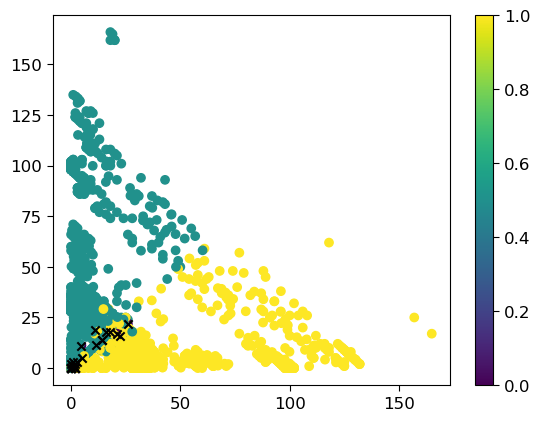

In [274]:
plot_first_step_phase(phase1_res)

oldphase1, oldphase2, phased1, phased2 = phase1_res
phased1 = phase_df['final_step_phase1'].values
phased2 = phase_df['final_step_phase2'].values
plt.scatter(oldphase1, oldphase2, c=1 + phased1.astype(int) + 2 * phased2.astype(int))
indices = phase_df.index[phase_df['allele1'] == 'N/A']
plt.scatter(oldphase1[indices], oldphase2[indices], c = 'black', marker = 'x')
plt.colorbar()

In [23]:
unphased_samples_to_remove = hlatypes.loc[indices, 'Sample ID'].tolist()
samples_to_remove = samples_to_remove + unphased_samples_to_remove

In [280]:
# QUILT phasing is in the order of maternal-paternal

trios = pd.read_csv('/well/band/users/rbx225/recyclable_files/ref_panels/oneKG/integrated_call_samples_v3.20200731.ALL.ped', sep = '\t')
trios = trios[trios['Individual ID'].isin(retained_samples)]
trios = trios[(trios['Paternal ID'].isin(retained_samples)) | (trios['Maternal ID'].isin(retained_samples))]
trios = trios[['Individual ID', 'Paternal ID', 'Maternal ID']]

trios['allele1'] = 'N/A'
trios['allele2'] = 'N/A'
undetermined_trios = []

def phase(r, gene, hlatypes = hlatypes):
    kid = r['Individual ID']
    pat = r['Paternal ID']
    mat = r['Maternal ID']
    
    lst_kid = hlatypes[hlatypes['Sample ID'] == kid][['HLA-' + gene + ' 1', 'HLA-' + gene + ' 2']].values[0]
    set_kid = set(lst_kid)
    
    pattypes = hlatypes[hlatypes['Sample ID'] == pat][['HLA-' + gene + ' 1', 'HLA-' + gene + ' 2']].values
    if len(pattypes) != 0:
        lst_pat = pattypes[0]
        set_pat = set(lst_pat)
    else:
        set_pat = {None}
        pattypes = None
    mattypes = hlatypes[hlatypes['Sample ID'] == mat][['HLA-' + gene + ' 1', 'HLA-' + gene + ' 2']].values
    if len(mattypes) != 0:
        lst_mat = mattypes[0]
        set_mat = set(lst_mat)
    else:
        set_mat = {None}
        mattypes = None
    
    if np.nan in set_kid:
        if len(set_kid) == 1:
            undetermined_trios.append(kid)
        elif len(set_kid) == 2:
            set_kid.discard(np.nan)
            kidtype = list(set_kid)[0]
            if np.nan not in (set_pat.union(set_mat)):
                if (kidtype in set_pat) and (kidtype not in set_mat):
                    r['allele1'] = kidtype
                elif (kidtype in set_mat) and (kidtype not in set_pat):
                    r['allele2'] = kidtype
                else:
                    pass
            else:
                if (np.nan not in set_mat) and (kidtype not in set_mat):
                    r['allele1'] = kidtype
                elif (np.nan not in set_pat) and (kidtype not in set_pat):
                    r['allele2'] = kidtype
                else:
                    undetermined_trios.append(kid)
    else:
        if len(set_kid) == 1:
            r['allele1'] = lst_kid[0]
            r['allele2'] = lst_kid[0]
        else:
            if (lst_kid[0] in set_pat) and (lst_kid[0] not in set_mat):
                if np.nan not in set_mat:
                    r['allele1'] = lst_kid[0]
                    r['allele2'] = lst_kid[1]
                else:
                    if lst_kid[1] not in set_pat:
                        r['allele1'] = lst_kid[0]
                        r['allele2'] = lst_kid[1]
                    else:
                        undetermined_trios.append(kid)
            elif (lst_kid[1] in set_pat) and (lst_kid[1] not in set_mat):
                if np.nan not in set_mat:
                    r['allele1'] = lst_kid[1]
                    r['allele2'] = lst_kid[0]
                else:
                    if lst_kid[0] not in set_pat:
                        r['allele1'] = lst_kid[1]
                        r['allele2'] = lst_kid[0]
                    else:
                        undetermined_trios.append(kid)  
            elif (lst_kid[0] in set_mat) and (lst_kid[0] not in set_pat):
                if np.nan not in set_pat:
                    r['allele1'] = lst_kid[1]
                    r['allele2'] = lst_kid[0]
                else:
                    if lst_kid[1] not in set_mat:
                        r['allele1'] = lst_kid[1]
                        r['allele2'] = lst_kid[0]
                    else:
                        undetermined_trios.append(kid)  
            elif (lst_kid[1] in set_mat) and (lst_kid[1] not in set_pat):
                if np.nan not in set_pat:
                    r['allele1'] = lst_kid[0]
                    r['allele2'] = lst_kid[1]
                else:
                    if lst_kid[0] not in set_mat:
                        r['allele1'] = lst_kid[0]
                        r['allele2'] = lst_kid[1]
                    else:
                        undetermined_trios.append(kid)  
    return r

trios = trios.apply(func = phase, args = (gene, hlatypes), axis = 1)

kgp_samples_idx = hlatypes.index[hlatypes['Sample ID'].isin(trios['Individual ID'])].to_numpy()
kgp_samples_phase = phased1[kgp_samples_idx]

phased_res = pd.DataFrame({'Sample ID': trios['Individual ID'].tolist(), 'allele1': reftypes1[kgp_samples_idx], 'allele2': reftypes2[kgp_samples_idx]})

for i in range(len(phased_res)):
    if kgp_samples_phase[i] == False:
        tmp = phased_res.iloc[i, 1]
        phased_res.iloc[i, 1] = phased_res.iloc[i, 2]
        phased_res.iloc[i, 2] = tmp

res = pd.merge(phased_res, trios[['Individual ID', 'allele1', 'allele2']], left_on = 'Sample ID', right_on = 'Individual ID', suffixes = ('_pred', '_true'))
res = res.drop(columns = 'Individual ID')
res

,Sample ID,allele1_pred,allele2_pred,allele1_true,allele2_true
0,HG00702,14:54,09:01,14:54,09:01
1,HG00733,11:04,03:01,11:04,03:01
2,HG02024,12:02,12:02,12:02,12:02
3,NA12878,03:01,01:01,03:01,01:01
4,NA19240,12:01,16:02,12:01,16:02
5,NA19675,07:01,03:01,07:01,03:01
6,NA19685,01:02,14:06,01:02,14:06
7,NA20318,15:03,11:02,11:02,15:03


In [ ]:
# RETAIN THIS!
# gamcc_hla = pd.read_csv('/well/band/users/rbx225/GAMCC/data/hla_direct_sequencing/HLA_direct_sequencing_all.csv')
# gamcc_hla = gamcc_hla[['SampleID', 'Locus', 'Included Alleles']]
# for s in gamcc_hla['SampleID'].unique():
#     tmps = gamcc_hla[gamcc_hla['SampleID'] == s]
#     for l in HLA_GENES:
#         tmpl = tmps[tmps['Locus'] == l]
#         repeat = 2 - tmpl.shape[0]
#         if repeat == 2:
#             gamcc_hla.loc[len(gamcc_hla)] = [s, l, np.nan]
#             gamcc_hla.loc[len(gamcc_hla)] = [s, l, np.nan]
#         if repeat == 1:
#             gamcc_hla.loc[len(gamcc_hla)] = [s, l, tmpl.iloc[0,2]]
                
# gamcc_hla = gamcc_hla[gamcc_hla['Locus'] == gene]
# gamcc_hla = gamcc_hla[['SampleID', 'Included Alleles']]

# gamcc_hla = pd.merge(gamcc_hla[::2], gamcc_hla[1::2], on = 'SampleID')
# gamcc_hla.columns = ['Sample ID', 'HLA-DRB1 1', 'HLA-DRB1 2']
# gamcc_hla

# x = gamcc_hla.iloc[0, 1]
# indices = []
# db_alleles = db.index.to_numpy()

# for a in x.split('/'):
#     old_a = a
#     while (gene + '*' + a) not in db.index and ':' in a:
#         a = a.rsplit(':', 1)[0]
#     if ':' in a:
#         indices.append(np.where(db_alleles == gene + '*' + a)[0][0])

# x = db.iloc[np.array(indices), :]